# Univariate Prophet Forecast for PC4 5501

https://facebook.github.io/prophet/docs/quick_start.html#python-api

https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [1]:
import pandas as pd
import os
import numpy as np
import pystan
import fbprophet
from fbprophet import Prophet
import matplotlib.pyplot as plt

In [2]:
# fbprophet v0.7.1
# pystan v2.19.1.1
print('fbprophet version ' + fbprophet.__version__)
print('pystan version ' + pystan.__version__)

fbprophet version 0.7.1
pystan version 2.19.1.1


In [3]:
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)
    
# sample dataset
df = pd.read_hdf('pc4_verbruiksdata_per_dag_5501.h5').reset_index()


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
df.rename(columns={"DATUM": "ds", "VERBRUIK": "y"}, inplace=True)

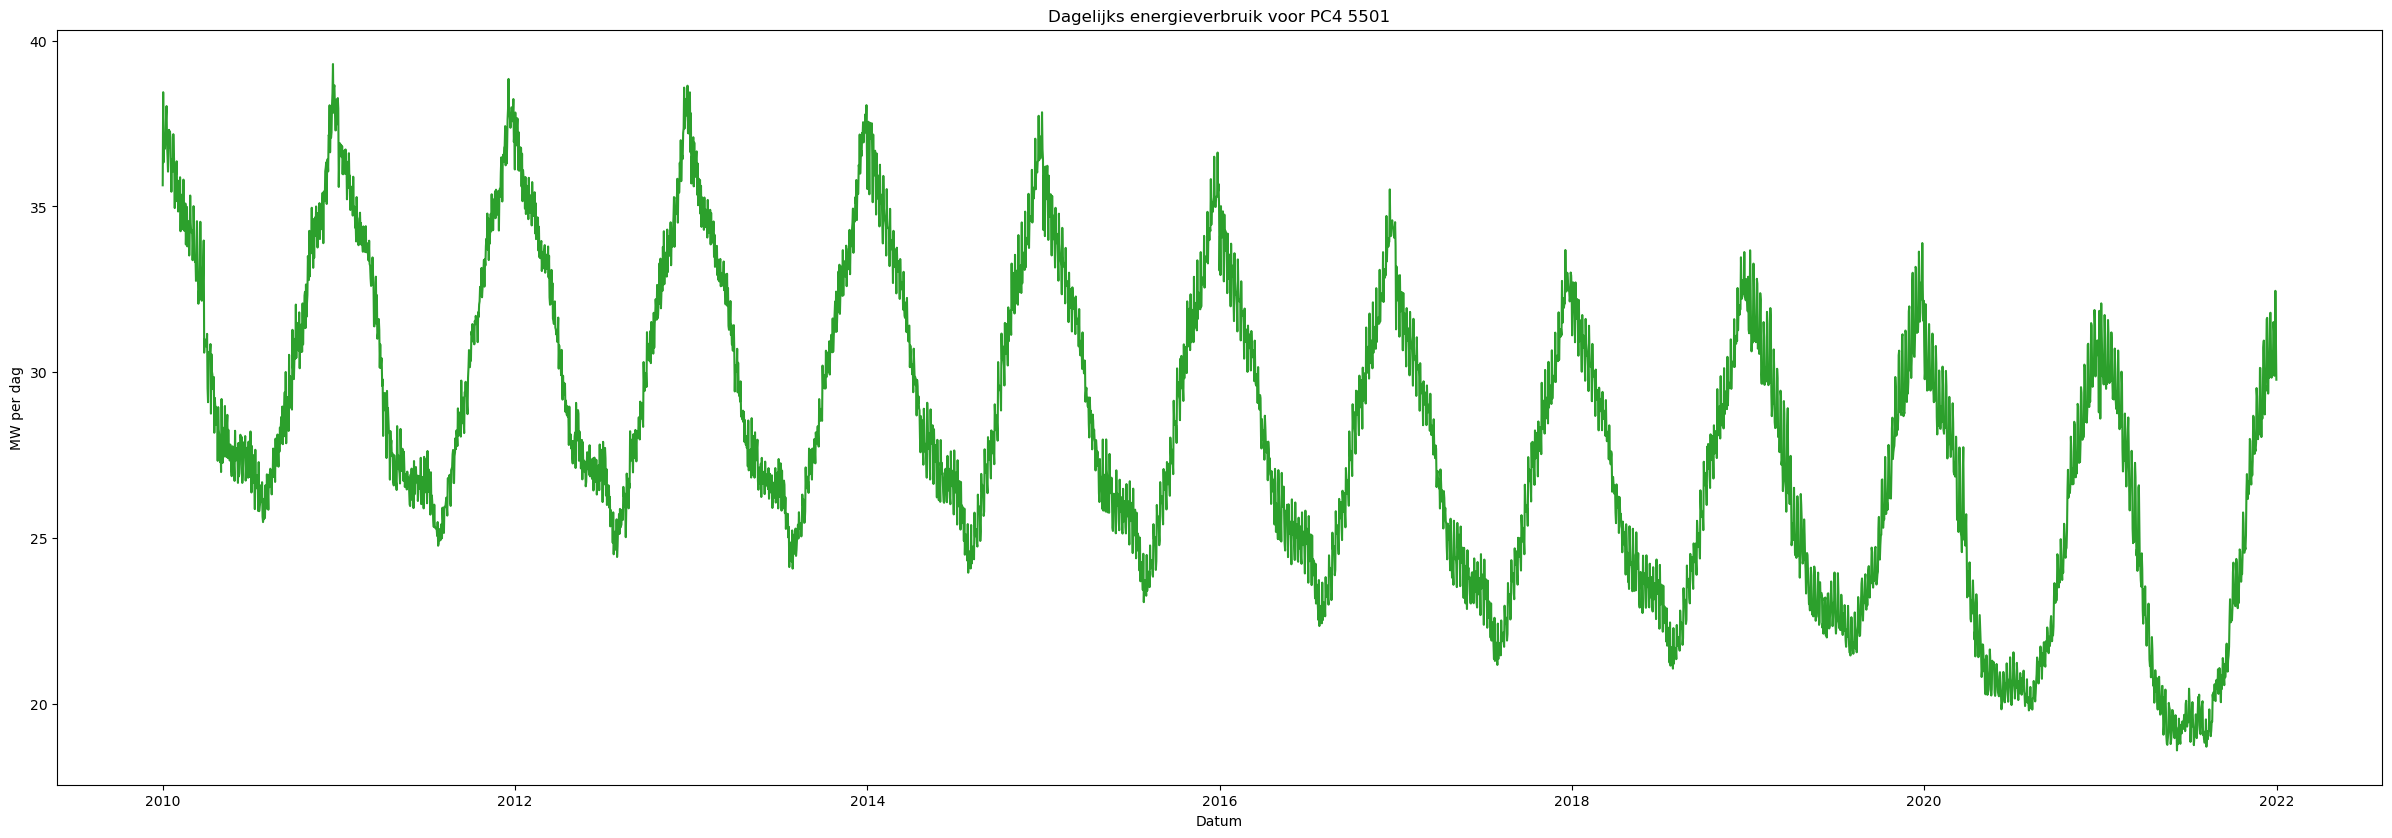

In [5]:
# Time series plot. Visuele check.
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df.ds, df.y, color='tab:green')
plt.gca().set(title=f'Dagelijks energieverbruik voor PC4 5501', xlabel='Datum', ylabel='MW per dag')
plt.show()

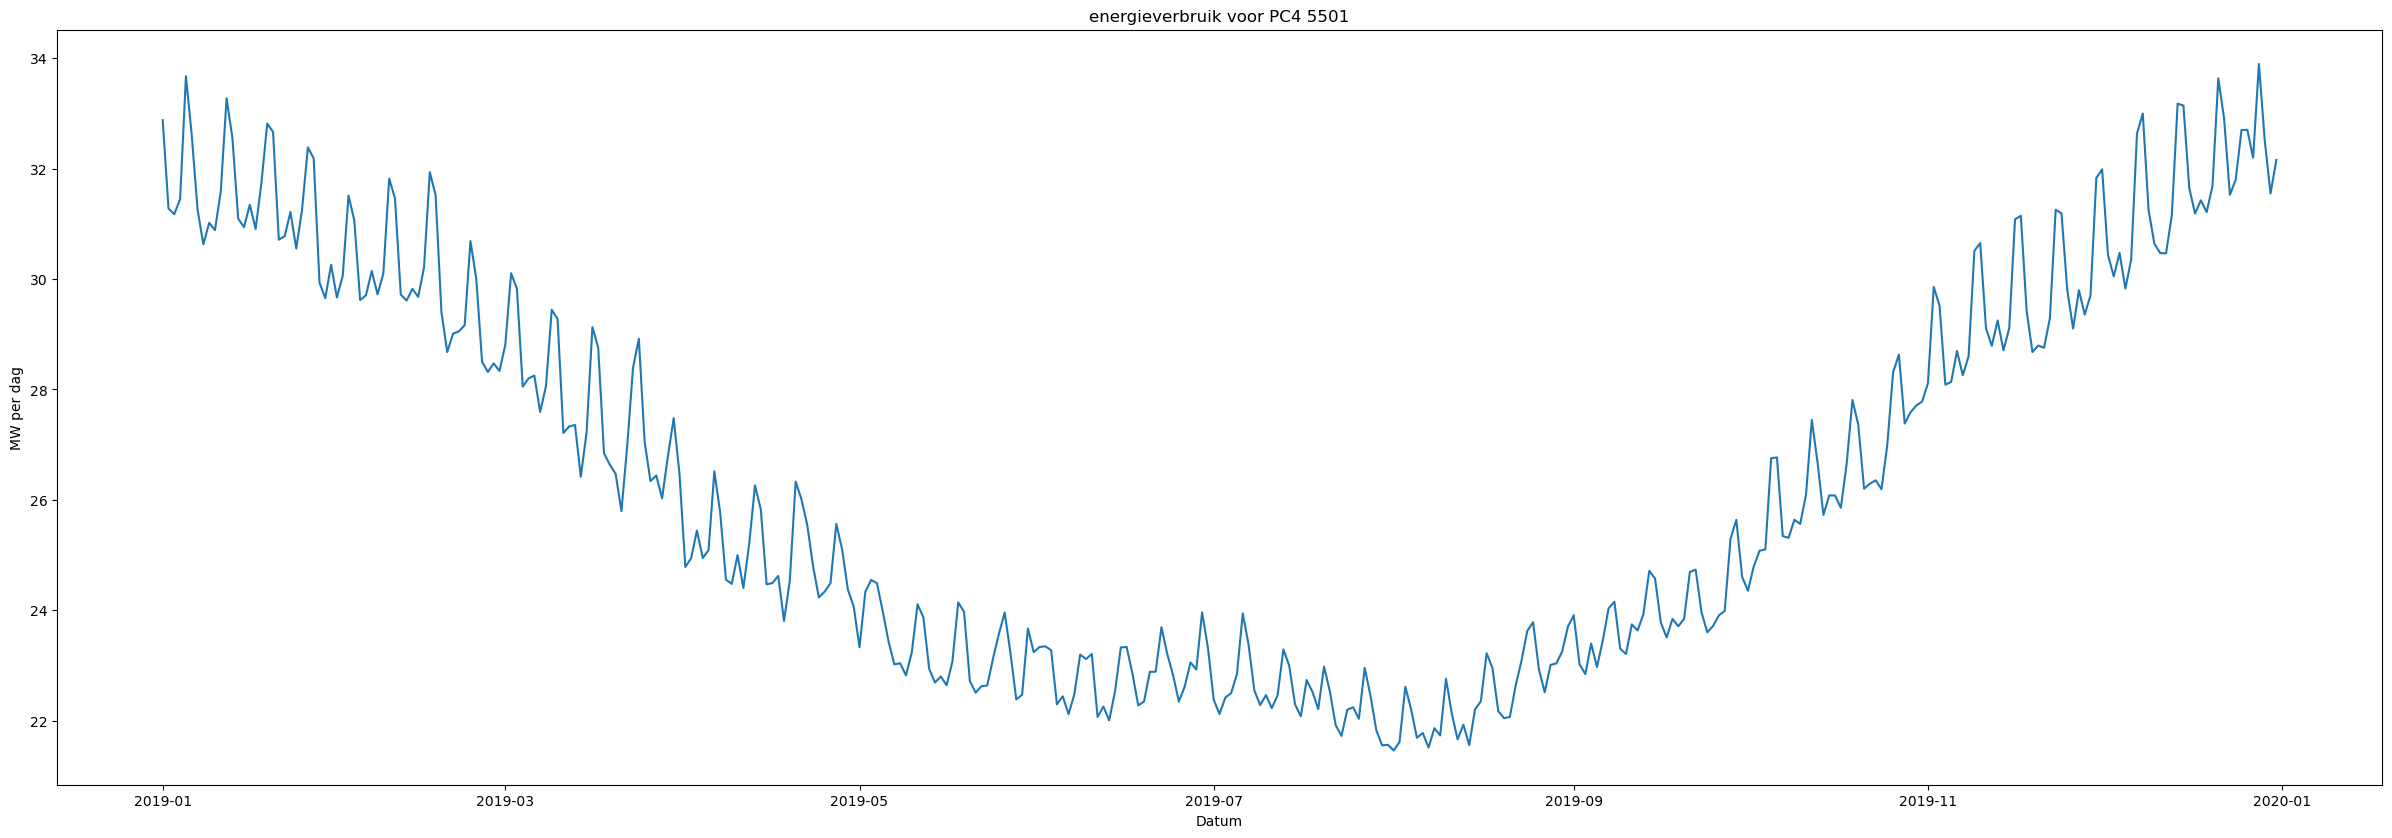

In [6]:
# Time series plot voor een bepaalde tijdsperiode
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df[df['ds'].isin(pd.date_range('2019-01-01 00:00:00', periods=365, freq='D'))].ds
       , df[df['ds'].isin(pd.date_range('2019-01-01 00:00:00', periods=365, freq='D'))].y
       , color='tab:blue')
plt.gca().set(title='energieverbruik voor PC4 5501', xlabel='Datum', ylabel='MW per dag')
plt.show()

In [7]:
df.head()

ds          y
0 2010-01-01  35.638680
1 2010-01-02  38.445606
2 2010-01-03  36.335540
3 2010-01-04  37.050146
4 2010-01-05  36.730582

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4383 non-null   datetime64[ns]
 1   y       4383 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 68.6 KB


### Train en Test dataset

In [9]:
split_date = '01-Jan-2018'
df_train = df.loc[df.ds <= split_date].copy()
df_test = df.loc[df.ds > split_date].copy()
print (f'Length full     dataset: {len(df)} samples')
print (f'Length training dataset: {len(df_train)} samples')
print (f'Length test     dataset: {len(df_test)} samples')

Length full     dataset: 4383 samples
Length training dataset: 2923 samples
Length test     dataset: 1460 samples


In [10]:
print(df_train.tail())

             ds          y
2918 2017-12-28  32.292617
2919 2017-12-29  33.008115
2920 2017-12-30  32.921803
2921 2017-12-31  32.500603
2922 2018-01-01  31.113076


### Train model

In [11]:
# important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
# holidays must be a DataFrame with "ds" and "holiday" columns.
# nieuwjaarsdag = pd.DataFrame({
#   'holiday': 'nieuwjaarsdag',
#   'ds': pd.to_datetime(['2010-01-01', '2011-01-01', '2012-01-01'
#                         , '2013-01-01', '2014-01-01', '2015-01-01'
#                         , '2016-01-01', '2017-01-01', '2018-01-01'
#                         , '2019-01-01', '2020-01-01', '2021-01-01']),
#   'lower_window': 0,
#   'upper_window': 1,
# })
# kerst = pd.DataFrame({
#   'holiday': 'kerst',
#   'ds': pd.to_datetime(['2010-12-25', '2010-12-26', '2011-12-25', '2011-12-26','2012-12-25', '2012-12-26',
#                         '2013-12-25', '2013-12-26', '2014-12-25', '2014-12-26','2015-12-25', '2015-12-26',
#                         '2016-12-25', '2016-12-26', '2017-12-25', '2017-12-26','2018-12-25', '2018-12-26',
#                         '2019-12-25', '2019-12-26', '2020-12-25', '2020-12-26','2021-12-25', '2021-12-26',]),
#   'lower_window': 0,
#   'upper_window': 1,
# })

# holidays = pd.concat((nieuwjaarsdag, kerst))

holidays = pd.DataFrame({'holiday': 'nieuwjaarsdag',
                         'ds': pd.to_datetime(['2010-01-01']),
                         'lower_window': 0,
                         'upper_window': 1,
})

In [12]:
# We fit the model by instantiating a new Prophet object.
# Any settings to the forecasting procedure are passed into the constructor. 
# Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.
m = Prophet(growth='linear',
    changepoints=None,
    n_changepoints=2, #25,
    changepoint_range=0.4, #0.8,
    yearly_seasonality=True, #'auto',
    weekly_seasonality=True, #'auto',
    daily_seasonality=False, #'auto',
    holidays= holidays, #None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None)
m.add_country_holidays(country_name='NL')  # holidays van Nederland toevoegen
m.fit(df_train)

In [13]:
# Python
m.train_holiday_names

0          nieuwjaarsdag
1          Nieuwjaarsdag
2         Eerste paasdag
3          Goede Vrijdag
4         Tweede paasdag
5             Hemelvaart
6     Eerste Pinksterdag
7     Tweede Pinksterdag
8        Eerste Kerstdag
9        Tweede Kerstdag
10            Koningsdag
11        Bevrijdingsdag
12         Koninginnedag
dtype: object

### Predictions voor de test data

In [14]:
future = pd.DataFrame(df_test['ds'])

In [15]:
future.tail()

ds
4378 2021-12-27
4379 2021-12-28
4380 2021-12-29
4381 2021-12-30
4382 2021-12-31

In [16]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
1455 2021-12-27  30.667088   28.182958   33.203212
1456 2021-12-28  29.755835   27.242454   32.159062
1457 2021-12-29  29.953945   27.630660   32.554663
1458 2021-12-30  29.849782   27.464607   32.409275
1459 2021-12-31  29.826659   27.336520   32.431257

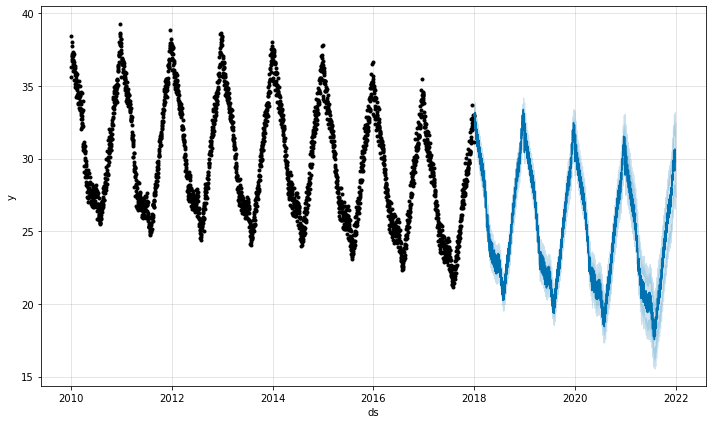

In [17]:
# You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.
fig1 = m.plot(forecast)

In [18]:
# forecast en actual combineren
df_test_all = pd.merge(df_test, forecast, on='ds', how='left')
df_test_all[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds          y       yhat  yhat_lower  yhat_upper
0 2018-01-02  31.969758  32.935347   32.269364   33.662932
1 2018-01-03  32.710845  33.091865   32.439247   33.764728
2 2018-01-04  32.439281  32.952416   32.259723   33.643384
3 2018-01-05  32.683431  32.900486   32.186420   33.602794
4 2018-01-06  32.017922  32.769362   32.093977   33.491351

<AxesSubplot:xlabel='ds'>

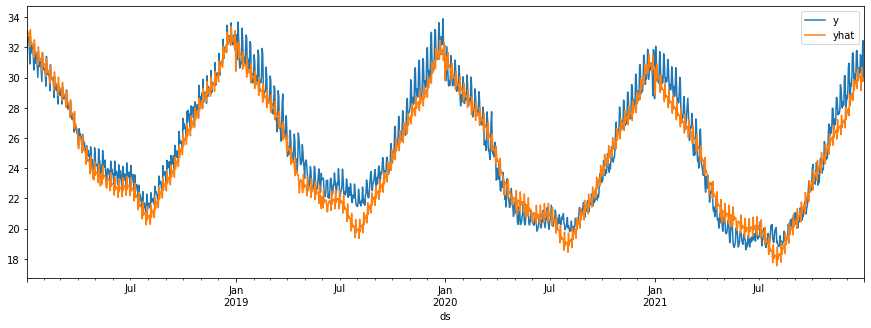

In [19]:
df_test_all.plot(x='ds', y=['y','yhat'], figsize=(15,5))

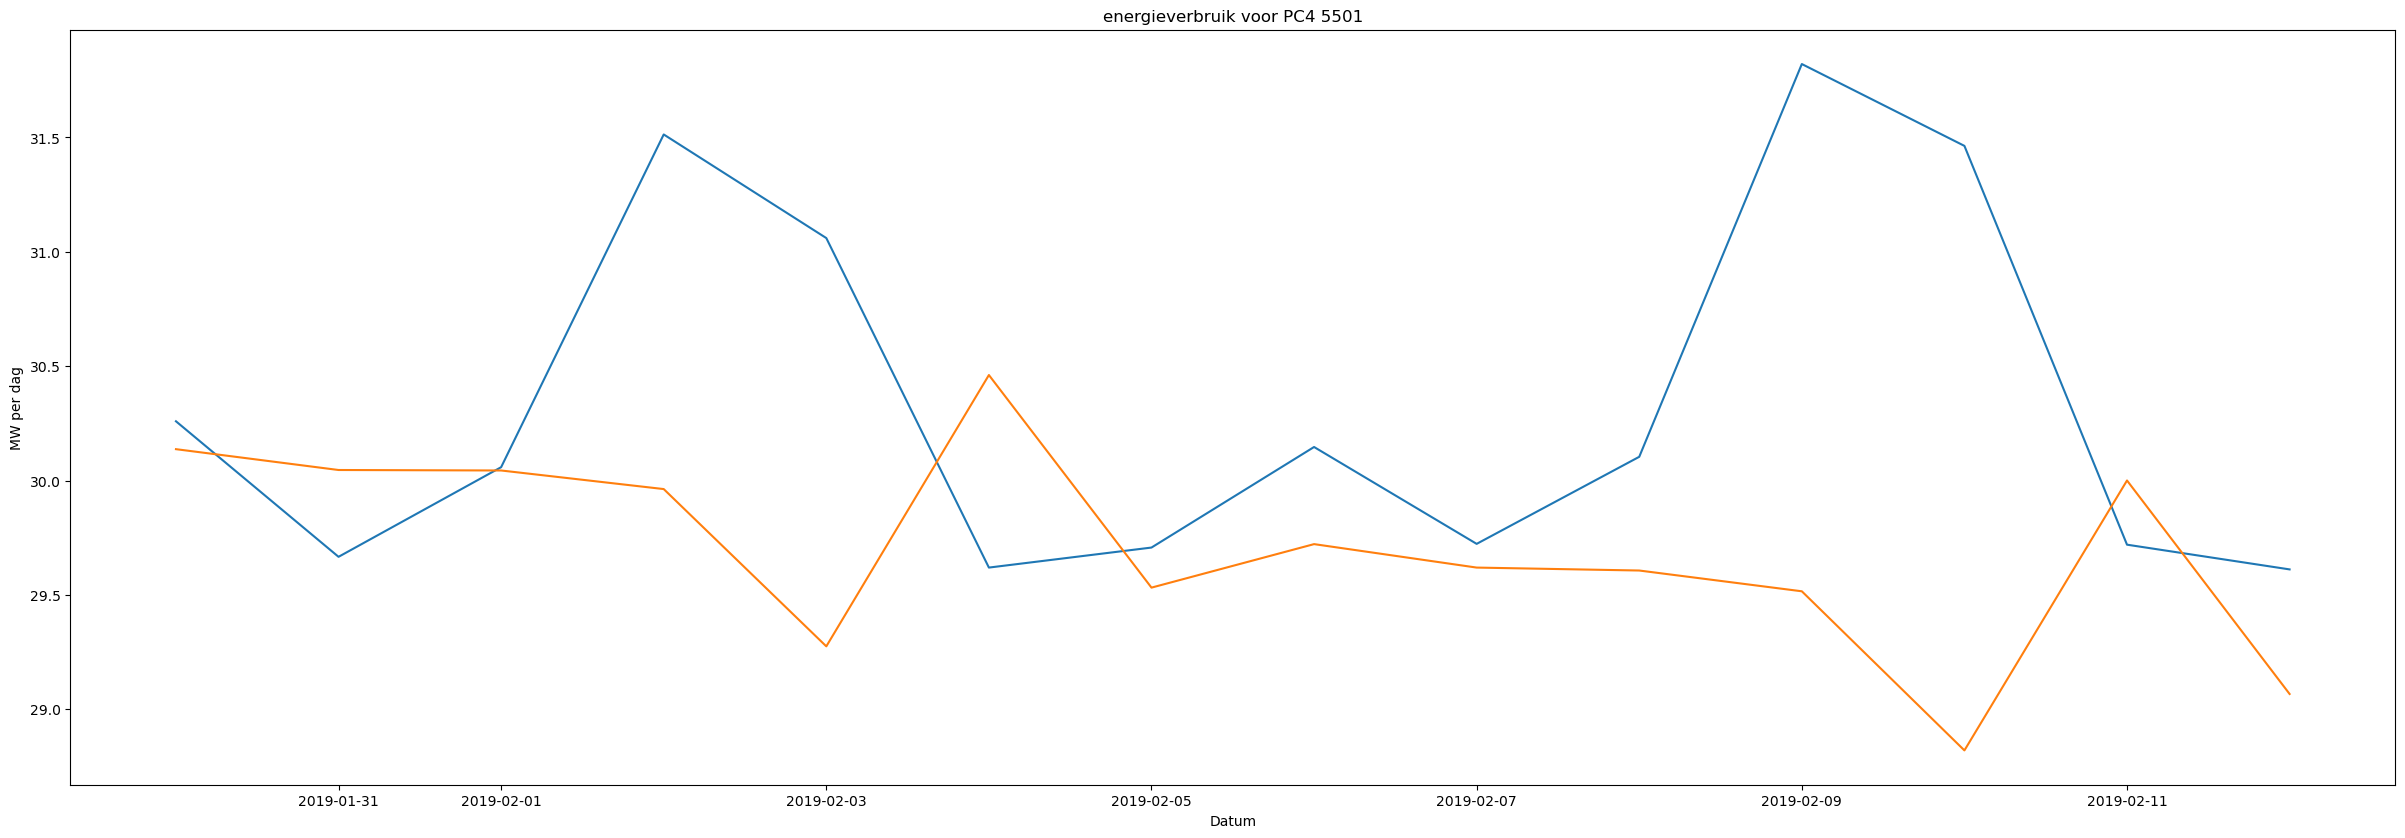

In [20]:
# Time series plot voor een bepaalde tijdsperiode
plt.figure(figsize=(30,10), dpi=100)
plt.plot(df_test_all[df_test_all['ds'].isin(pd.date_range('2019-01-30 00:00:00', periods=14, freq='D'))][['ds']]
       , df_test_all[df_test_all['ds'].isin(pd.date_range('2019-01-30 00:00:00', periods=14, freq='D'))][['y','yhat']]
       )
plt.gca().set(title='energieverbruik voor PC4 5501', xlabel='Datum', ylabel='MW per dag')
plt.show()

In [21]:
df_all = pd.concat([df_train, df_test_all], sort = False)

<AxesSubplot:xlabel='ds'>

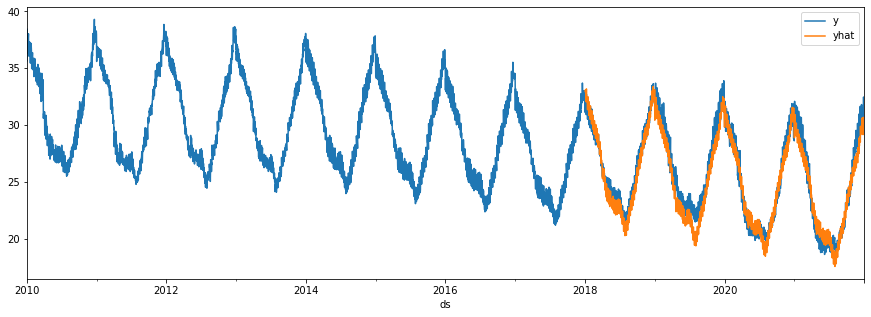

In [22]:
df_all.plot(x='ds', y=['y','yhat'], legend=True, figsize=(15,5))

### Evaluate the Performance

In [23]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
test_error = mean_absolute_percentage_error(df_test_all['y'],df_test_all['yhat'])

print('MAPE  test: %.2f' % test_error)
print(f'Mean absolute percent accuracy: {100 - test_error:.2f}%')

MAPE  test: 3.23
Mean absolute percent accuracy: 96.77%


all default: \
MAPE  test: 8.47\
Mean absolute percent accuracy: 91.53%

n_changepoints=2 \
changepoint_range=0.4 \
MAPE  test: 3.20 \
Mean absolute percent accuracy: 96.80%



### Plots

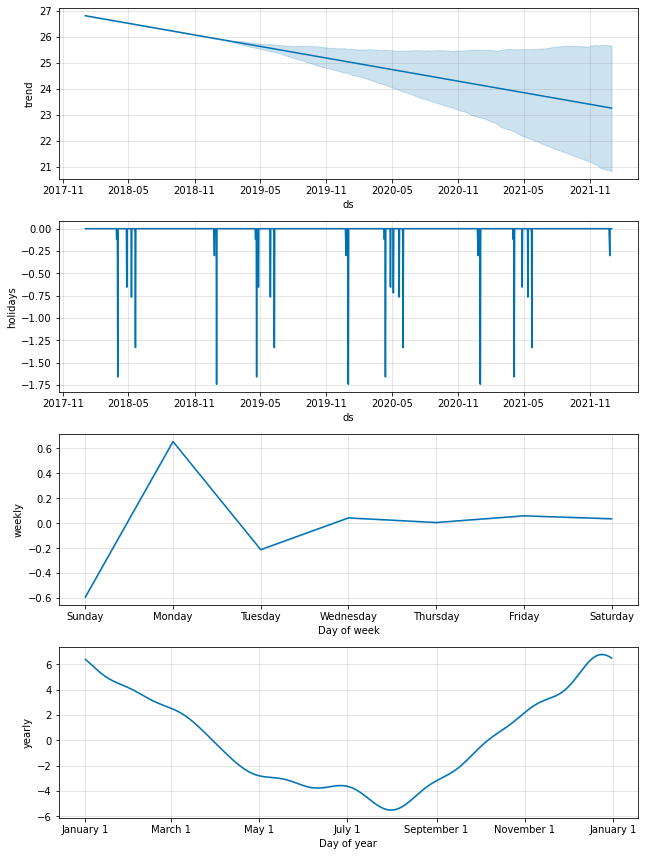

In [25]:
# If you want to see the forecast components, you can use the Prophet.plot_components method. 
# By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. 
# If you include holidays, you’ll see those here, too.
fig2 = m.plot_components(forecast)


In [26]:
# An interactive figure of the forecast and components can be created with plotly. 
# You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. 
# You will also need to install the notebook and ipywidgets packages.
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [27]:
plot_components_plotly(m, forecast)